 # Notebook 2: Handling Imbalance with SMOTE and BalancedRandomForest + HPO

## 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

## 2. Load Data

In [2]:
train = pd.read_csv("imbtrain.csv", na_values=[], keep_default_na=False)
test = pd.read_csv("imbtest.csv", na_values=[], keep_default_na=False)

In [3]:
train.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,ME,66,510,No,No,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1,False
1,AR,86,408,No,Yes,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0,False
2,KS,65,415,No,Yes,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4,False
3,WV,95,415,No,No,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1,False
4,TN,105,408,No,No,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1,False


In [4]:
train['Churn'].value_counts()

,count
Churn,
False,2281
True,81


In [5]:
train['Churn'].value_counts(normalize=True)

,proportion
Churn,
False,0.965707
True,0.034293


In [6]:
test['Churn'].value_counts()

,count
Churn,
False,569
True,22


In [7]:
test['Churn'].value_counts(normalize=True)

,proportion
Churn,
False,0.962775
True,0.037225


## 3. Preprocessing

In [8]:
def preprocess(df):
    # TODO: copy our preprocess function from part 1 and augment it anyway you like
    df = df.copy()
    df['Churn'] = df['Churn'].map({True: 1, False: 0})
    df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
    df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})
    df = df.drop(columns=['State'])  # Drop high cardinality feature for now
    return df

In [9]:
post_train = preprocess(train)
post_test = preprocess(test)

In [10]:
post_train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,66,510,0,0,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1,0
1,86,408,0,1,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0,0
2,65,415,0,1,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4,0
3,95,415,0,0,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1,0
4,105,408,0,0,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1,0


In [11]:
X_train = post_train.drop('Churn', axis=1)
y_train = post_train['Churn']
X_test = post_test.drop('Churn', axis=1)
y_test = post_test['Churn']

In [12]:
X_train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,66,510,0,0,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1
1,86,408,0,1,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0
2,65,415,0,1,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4
3,95,415,0,0,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1
4,105,408,0,0,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1


In [13]:
y_train.head(5)

,Churn
0,0
1,0
2,0
3,0
4,0


#### Helper function for evaluation

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {title} ---")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()
    print("ROC-AUC:", roc_auc_score(y_test, y_scores))
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr)
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

## 4.a. Random Forest


--- Minority Class Oversampling + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       569
           1       1.00      0.36      0.53        22

    accuracy                           0.98       591
   macro avg       0.99      0.68      0.76       591
weighted avg       0.98      0.98      0.97       591



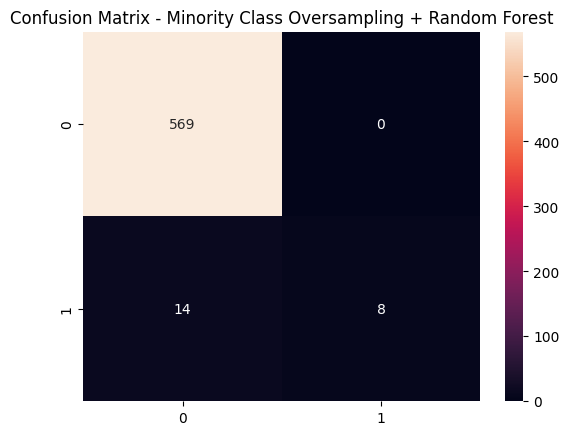

ROC-AUC: 0.9648506151142355


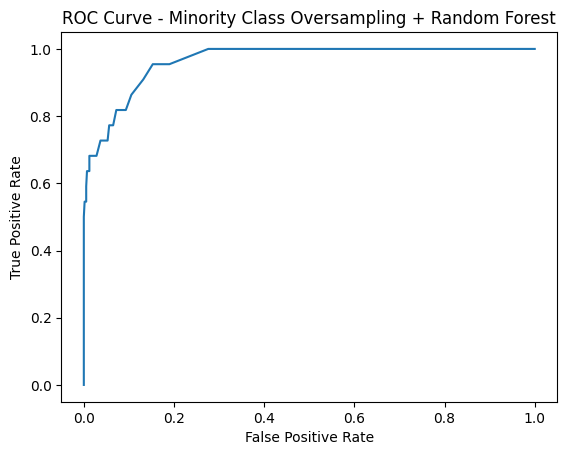

In [15]:
# TODO: Fit a Random Forest classifier over the imbalanced dataset and evaluate it
# clf = ?
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test, "Minority Class Oversampling + Random Forest")


## 4.b. Minority Class Oversampling + Random Forest

In [16]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# TODO: Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_mcos, y_mcos = ros.fit_resample(X_train, y_train)

In [17]:
y_mcos.value_counts()

,count
Churn,
0,2281
1,2281



--- Minority Class Oversampling + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       569
           1       0.89      0.36      0.52        22

    accuracy                           0.97       591
   macro avg       0.93      0.68      0.75       591
weighted avg       0.97      0.97      0.97       591



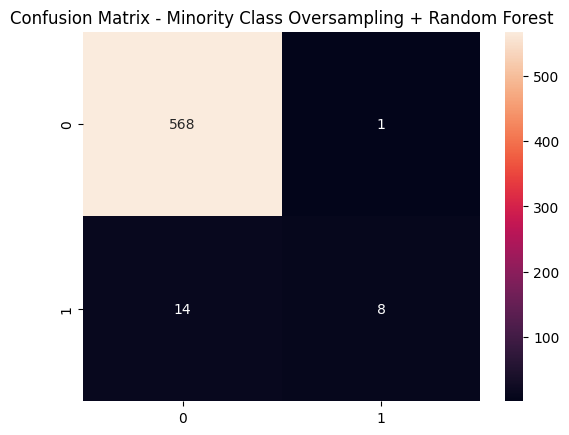

ROC-AUC: 0.946556957980508


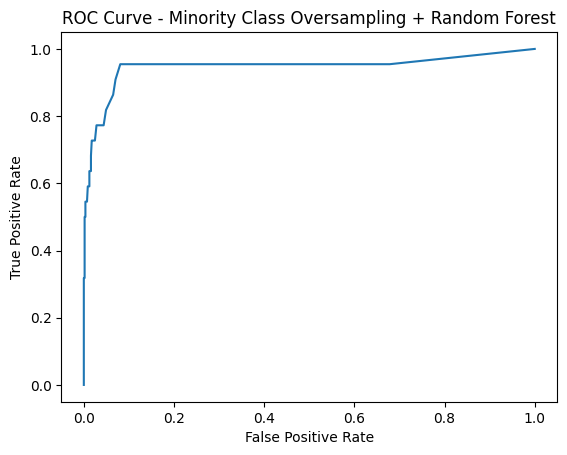

In [18]:
# TODO: fit RandomForest over the new dataset and evaluate it
clf_mcos = RandomForestClassifier(random_state=42)
clf_mcos.fit(X_mcos, y_mcos)
evaluate_model(clf_mcos, X_test, y_test, "Minority Class Oversampling + Random Forest")

In [19]:
# TODO: Use sampling_strategy=0.3 to more gently oversample the minority class
ros = RandomOverSampler(random_state=42, sampling_strategy=0.3)
X_mcus, y_mcus = ros.fit_resample(X_train, y_train)

In [20]:
y_mcus.value_counts()

,count
Churn,
0,2281
1,684


## 4.c. Majority Class Undersampling + Random Forest

After Random Undersampling: Counter({0: 81, 1: 81})

--- Majority Class Undersampling + Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       569
           1       0.16      0.95      0.27        22

    accuracy                           0.81       591
   macro avg       0.58      0.88      0.58       591
weighted avg       0.97      0.81      0.87       591



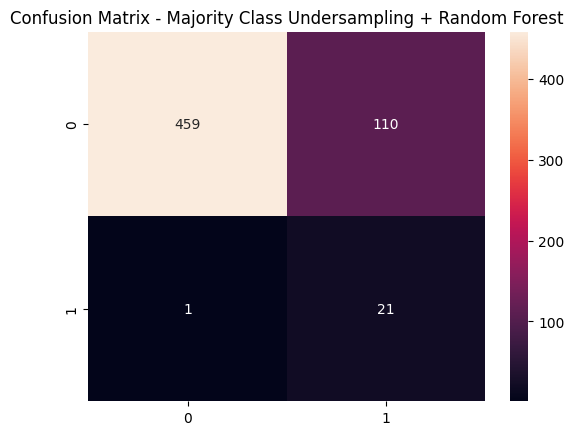

ROC-AUC: 0.9405256430739735


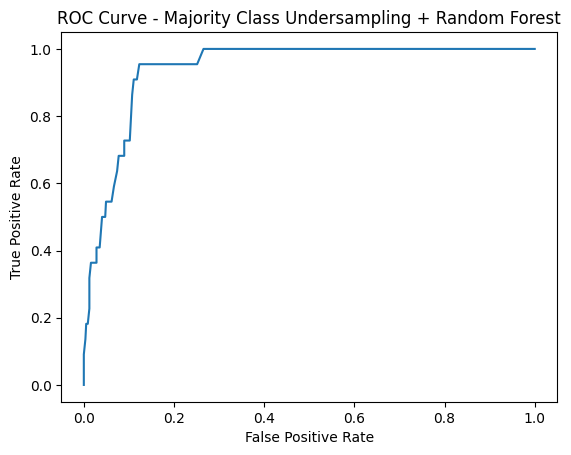

In [21]:
from imblearn.under_sampling import RandomUnderSampler
# TODO: Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_mus, y_mus = rus.fit_resample(X_train, y_train)

# X_mcus, y_mcus = ?
print("After Random Undersampling:", Counter(y_mus))
# TODO: fit RandomForest over the new dataset and evaluate it
clf_mus = RandomForestClassifier(random_state=42)
clf_mus.fit(X_mus, y_mus)
evaluate_model(clf_mus, X_test, y_test, "Majority Class Undersampling + Random Forest")

In [22]:
# TODO: Use sampling_strategy=0.3 to more gently oversample the minority class
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.3)
X_mus, y_mus = rus.fit_resample(X_train, y_train)

In [23]:
y_mus.value_counts()

,count
Churn,
0,270
1,81



--- Majority Class Undersampling  + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       569
           1       0.27      0.59      0.37        22

    accuracy                           0.92       591
   macro avg       0.62      0.76      0.66       591
weighted avg       0.96      0.92      0.94       591



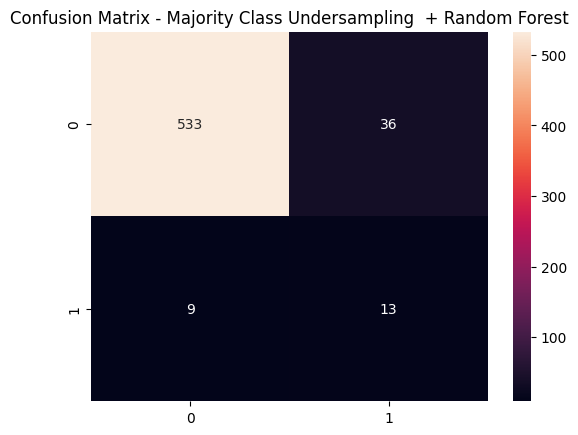

ROC-AUC: 0.9487138520530436


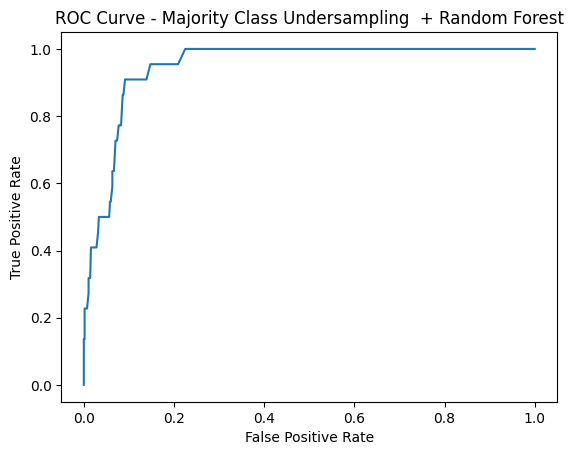

In [24]:
clf_mcus = RandomForestClassifier(random_state=42)
clf_mcus.fit(X_mus, y_mus)
evaluate_model(clf_mcus, X_test, y_test, "Majority Class Undersampling  + Random Forest")

## 4.d. Majority + Minority Class Under/oversampling + Random Forest

In [25]:
# TODO: Oversample and then undersample
ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_temp, y_temp = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
X_combo, y_combo = rus.fit_resample(X_temp, y_temp)


print("After Combined Sampling:", Counter(y_combo))
# TODO: fit RandomForest over the new dataset and evaluate it

After Combined Sampling: Counter({0: 1425, 1: 1140})



--- Majority Class Undersampling  + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       569
           1       0.73      0.50      0.59        22

    accuracy                           0.97       591
   macro avg       0.86      0.75      0.79       591
weighted avg       0.97      0.97      0.97       591



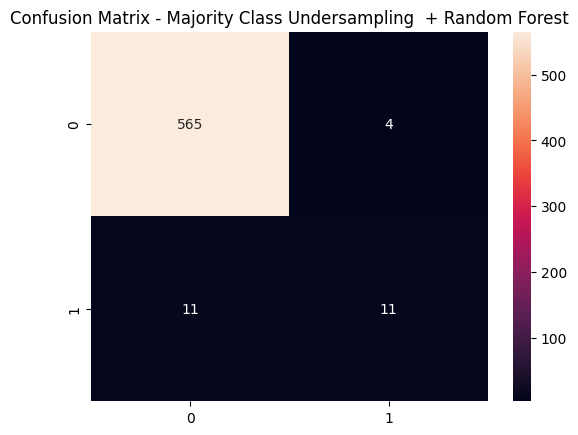

ROC-AUC: 0.9734781914043776


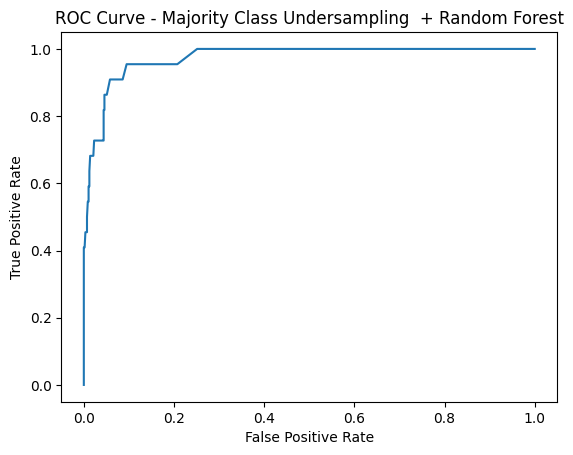

In [26]:
clf_combo = RandomForestClassifier(random_state=42)
clf_combo.fit(X_combo, y_combo)
evaluate_model(clf_combo, X_test, y_test, "Majority Class Undersampling  + Random Forest")

## 4.e SMOTE + Regular Random Forest

In [27]:
from imblearn.over_sampling import SMOTE


--- SMOTE + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.57      0.36      0.44        22

    accuracy                           0.97       591
   macro avg       0.77      0.68      0.71       591
weighted avg       0.96      0.97      0.96       591



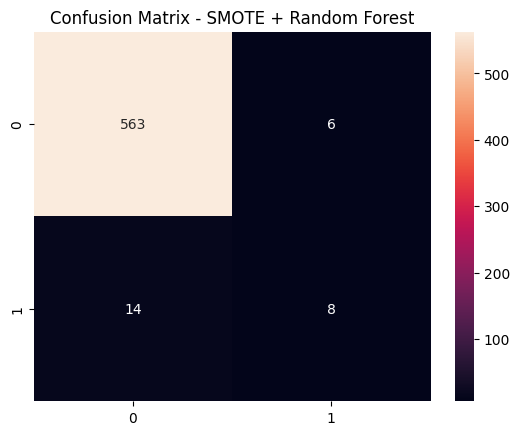

ROC-AUC: 0.907453267295095


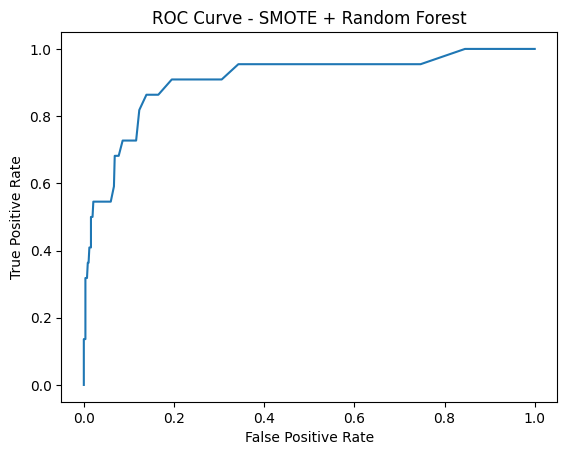

In [28]:
smote = SMOTE(random_state=42)
# TODO: Use SMOTE to get new X and y from training, with more fraud cases!
# documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# X_sm, y_sm = ?
# TODO: Fit a random forest classifier over the augmented training data
# clf_smote = ?
X_sm, y_sm = smote.fit_resample(X_train, y_train)
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_sm, y_sm)
evaluate_model(clf_smote, X_test, y_test, "SMOTE + Random Forest")



### 4.5. SMOTE + Regular Random Forest w/ HPO

In [29]:
from sklearn.model_selection import GridSearchCV


--- SMOTE + Random Forest (HPO) ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.60      0.41      0.49        22

    accuracy                           0.97       591
   macro avg       0.79      0.70      0.73       591
weighted avg       0.96      0.97      0.96       591



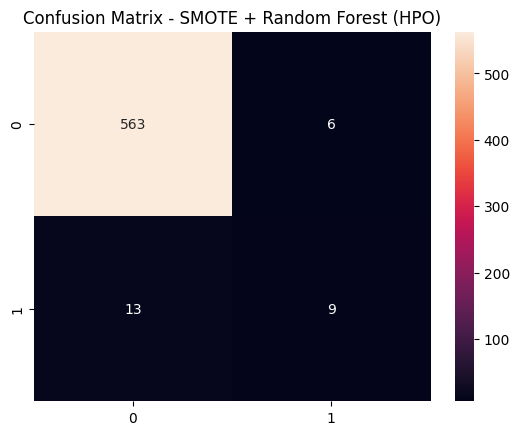

ROC-AUC: 0.9049768333599616


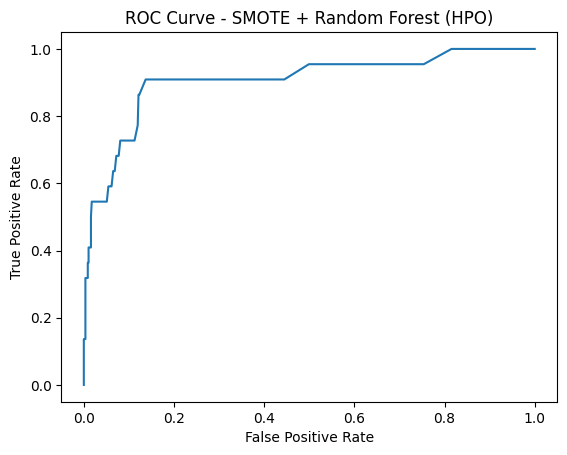

In [30]:
# TODO: Define a dict with hyperparameters to optimize/tune: Use n_estimators and max_depth.
# What is a good range for them? Consult the internet.
# rf_params = ?
# Use the GridSearchCV class to automatically fit and evaluate many RandomForest classifiers
# with different values for these hyperparameters, and also automatically find the best performing one.
# best performing how? Notice the `scoring` argument!
# gs_rf = ?
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

rf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [None, 10, 20, 30]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='roc_auc', cv=4, n_jobs=-1)
gs_rf.fit(X_sm, y_sm)
evaluate_model(gs_rf.best_estimator_, X_test, y_test, "SMOTE + Random Forest (HPO)")


## 5. Balanced Random Forest (no SMOTE)

In [31]:
from imblearn.ensemble import BalancedRandomForestClassifier


--- Balanced Random Forest Only ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       569
           1       0.30      0.95      0.46        22

    accuracy                           0.92       591
   macro avg       0.65      0.94      0.71       591
weighted avg       0.97      0.92      0.94       591



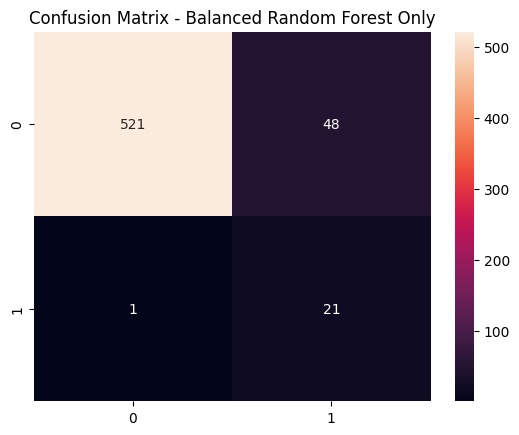

ROC-AUC: 0.9624540661447516


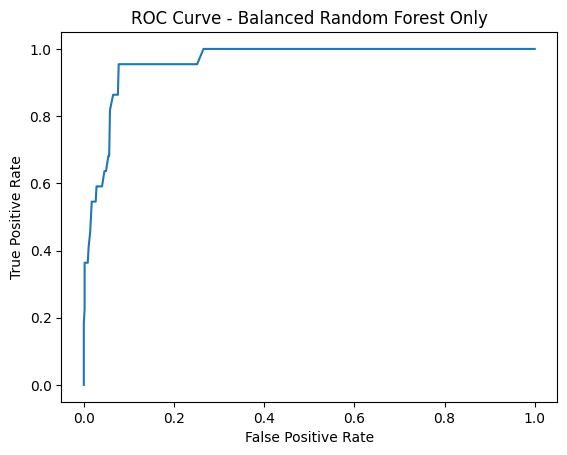

In [32]:
# TODO: Find a BALANCED version of the random forest classifier in the `imblearn` python package.
# Import it. Create a classifier. Fit it on the REGULAR imbalanced dataset (NOT the one you augmented with SMOTE).
# Then, evaluate it.
# from imblearn.? import ?
# clf_balrf = ?
clf_balrf = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
clf_balrf.fit(X_train, y_train)
evaluate_model(clf_balrf, X_test, y_test, "Balanced Random Forest Only")


### 5.5. Balanced Random Forest (no SMOTE) w/ HPO


--- Balanced Random Forest Only (HPO) ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       569
           1       0.28      0.91      0.43        22

    accuracy                           0.91       591
   macro avg       0.64      0.91      0.69       591
weighted avg       0.97      0.91      0.93       591



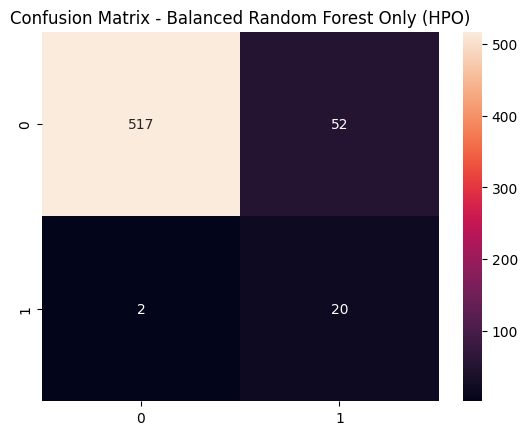

ROC-AUC: 0.9609362517974117


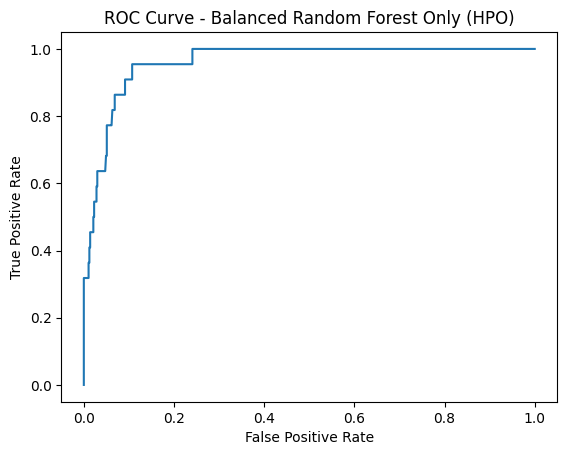

In [33]:
# TODO: Use GridSearchCV to find the best hyperparameters for the balanced random forest.
# Pick 2 or 3 hyperparameters. You can use the same ones, or explore the class definition to choose others.
# brf_params = ?
# gs_brf = ?
brf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [None, 10, 20, 30]}
gs_brf = GridSearchCV(BalancedRandomForestClassifier(random_state=42), brf_params, scoring='roc_auc', cv=3, n_jobs=-1)
gs_brf.fit(X_train, y_train)
evaluate_model(gs_brf.best_estimator_, X_test, y_test, "Balanced Random Forest Only (HPO)")


## 6. SMOTE + Balanced Random Forest


--- SMOTE + Balanced Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.62      0.45      0.53        22

    accuracy                           0.97       591
   macro avg       0.80      0.72      0.76       591
weighted avg       0.97      0.97      0.97       591



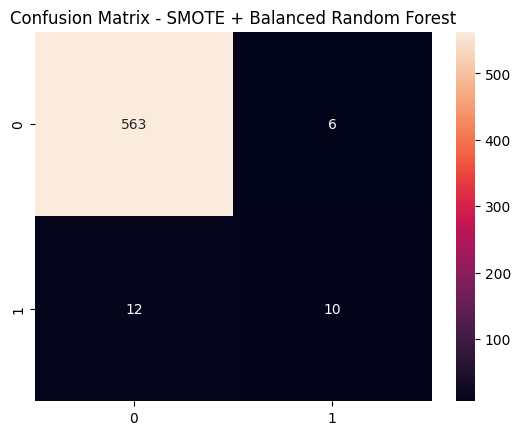

ROC-AUC: 0.9180779677264739


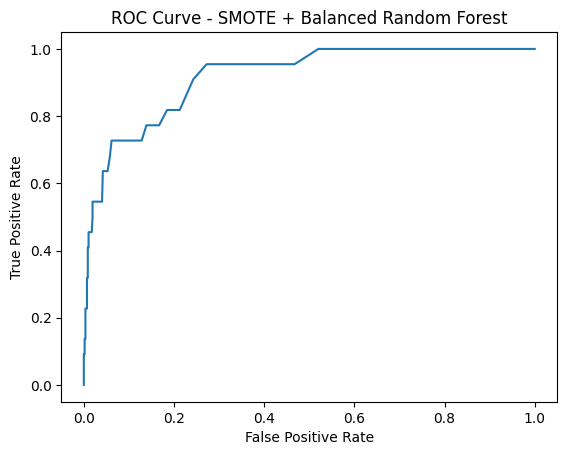

In [34]:
# TODO: Create a new balabced random forest classifier,
# and fit it on the SMOTE-augmented data. Then evaluate it.
# clf_comb = ?
X_comb, y_comb = smote.fit_resample(X_train, y_train)
clf_comb = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
clf_comb.fit(X_comb, y_comb)
evaluate_model(clf_comb, X_test, y_test, "SMOTE + Balanced Random Forest")
